In [1]:
DATASET_TYPE = 'dataset_2'
ARCHITECTURE = 'mobilenet'

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

In [3]:
# splitting the dataset into specific folders for train, validate and test
import splitfolders

source_folder = f'{DATASET_TYPE}'
target_folder = f'{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 14658 files [00:04, 3145.15 files/s]


In [4]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_dataset_length = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['early blight', 'healthy', 'late blight', 'mosaic virus', 'powdery mildew', 'septoria']


In [5]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# modifying architecture output classes
class MobileNetV2(nn.Module):
  def __init__(self, num_of_classes):
    super(MobileNetV2, self).__init__()
    self.model = mobilenet_v2(weights=None)
    features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [8]:

# Training model using different learning rates

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rates = [0.01, 0.001, 0.0001]

for learning_rate in (learning_rates):

  epochs = 15

  model = MobileNetV2(num_of_classes=len(dataset_classes))
  model = model.to(device)
  optimizer = Adam(model.parameters(), lr=learning_rate)
  loss_function = CrossEntropyLoss()

  train_losses = []
  train_accuracies = []
  validate_losses = []
  validate_accuracies = []

  print(f"learning rate: ---------------> {learning_rate}")

  for epoch in range(epochs):

    print(f"epoch number ---> {epoch + 1} ")

    model.train()
    train_batch_loss = 0.0
    train_correct_predictions = 0
    train_samples = 0
    for xtrain, ytrain in train_loader:

      optimizer.zero_grad()

      xtrain = xtrain.to(device)
      ytrain = ytrain.to(device)
      train_prob = model(xtrain)

      # calculating batch accuracy
      _, train_prediction = torch.max(train_prob, 1)
      train_samples += ytrain.size(0)
      train_correct_predictions += (train_prediction == ytrain).sum().item()

      loss = loss_function(train_prob, ytrain)
      loss.backward()
      optimizer.step()

      # calculating batch loss
      train_batch_loss += loss.item()

    # calculating train loss for epoch
    train_loss = train_batch_loss / len(train_loader)
    train_losses.append(train_loss)

    # calculating train accuracy for epoch
    train_accuracy = 100 * (train_correct_predictions / train_samples)
    train_accuracies.append(train_accuracy)
    print("training loss: {:.4f}  training accuracy: {:.2f} %".format(train_loss, train_accuracy))

    validate_batch_loss = 0.0
    validate_correct_predictions = 0
    validate_samples = 0
    model.eval()
    with torch.no_grad():
      for xvalidate, yvalidate in validate_loader:

        optimizer.zero_grad()

        xvalidate = xvalidate.to(device)
        yvalidate = yvalidate.to(device)
        validate_prob = model(xvalidate)

        #calculating batch accuracy
        _, validate_prediction = torch.max(validate_prob, 1)
        validate_samples += yvalidate.size(0)
        validate_correct_predictions += (validate_prediction == yvalidate).sum().item()

        loss = loss_function(validate_prob, yvalidate)

        #calculating batch loss
        validate_batch_loss += loss.item()

    # calculating validate loss for epoch
    validate_loss = validate_batch_loss / len(validate_loader)
    validate_losses.append(validate_loss)

    # calculating validate accuracy for epoch
    validate_accuracy = 100 * (validate_correct_predictions / validate_samples)
    validate_accuracies.append(validate_accuracy)
    print("validation loss: {:.4f}  validation accuracy: {:.2f} %".format(validate_loss, validate_accuracy))

  print(f"training and validation for {epochs} epochs completed")
  print(f"train losses: {train_losses}")
  print(f"train accuracies: {train_accuracies}")
  print(f"validation losses: {validate_losses}")
  print(f"validation accuracies: {validate_accuracies}")

  # saving metrics to a file
  np.savez(f'{ARCHITECTURE}_{learning_rate}_metrics.npz',
          train_losses=train_losses,
          train_accuracies=train_accuracies,
          validate_losses=validate_losses,
          validate_accuracies=validate_accuracies)

learning rate: ---------------> 0.01
epoch number ---> 1 
training loss: 1.5620  training accuracy: 38.73 %
validation loss: 1.5395  validation accuracy: 49.89 %
epoch number ---> 2 
training loss: 1.1692  training accuracy: 53.74 %
validation loss: 1.4665  validation accuracy: 49.20 %
epoch number ---> 3 
training loss: 1.0654  training accuracy: 59.01 %
validation loss: 1.0115  validation accuracy: 62.19 %
epoch number ---> 4 
training loss: 0.9963  training accuracy: 61.45 %
validation loss: 0.9242  validation accuracy: 63.74 %
epoch number ---> 5 
training loss: 0.9326  training accuracy: 64.88 %
validation loss: 0.8398  validation accuracy: 67.33 %
epoch number ---> 6 
training loss: 0.8954  training accuracy: 65.66 %
validation loss: 1.0192  validation accuracy: 62.05 %
epoch number ---> 7 
training loss: 0.8539  training accuracy: 67.05 %
validation loss: 0.8381  validation accuracy: 66.70 %
epoch number ---> 8 
training loss: 0.8505  training accuracy: 67.62 %
validation loss: 

In [25]:
x1 = np.load('mobilenet_0.01_metrics.npz')
val_loss = x1['validate_losses']
x2 = np.load('mobilenet_0.001_metrics.npz')
val_loss2 = x2['validate_losses']
x3 = np.load('mobilenet_0.0001_metrics.npz')
val_loss3 = x3['validate_losses']

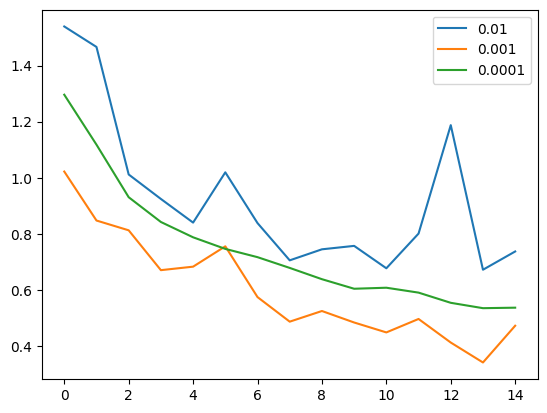

In [26]:
plt.plot(val_loss,label='0.01')
plt.plot(val_loss2,label='0.001')
plt.plot(val_loss3,label='0.0001')
plt.legend()
plt.show()
